# CS5100 Final Project

Name: Harjis Ahuja

Goal: This assignment will allow you to apply your knowledge of machine learning that you have aquired in this course on a real-world dataset of your choosing per the assignment specifications.

Complete the notebook and demonstrate your mastery of the topic.

## Prerequisites

In this section describe any packages that need to be installed or any additional setup that needs to take place before trying to run code.

## Problem

In this section, you will explain the problem you are trying to solve, the things you are trying to learn, and how you want to visualize the results.

To predict KPMI/ MBTI (Myers-Briggs Type Indicator) Personality Type along with suited profession for an individual as this helps them to understand their strengths and weaknesses, also a realization that why people are different and why they react differently to different situations. 
This is a fun activity to gain some understanding and perspective of people.



## Data

In this section you will describe the dataset (corpus) you are using. Explain who collected the data, how they did it, the manner in which it was stored, the way you accessed the data, what steps you will have to do to clean it, and so on. Provide any relavent details.

This data is taken from kaggle Licensced by Attribution-NonCommercial 4.0 International (CC BY-NC 4.0), collected by kpmi.ru (B2C service website) , which has 100,000 answers to the questionnaires (questionnaire_schema.json).
The data is stored such that there are two possible answers to each question and the time taken to respond to each question. As well as there are raw values of each type E,I,S,N,T,F,J and P, using which the Personality type is mentioned.
Not much preprocessing of cleaning of data was required.

In [1]:

import pandas as pd

from sklearn.model_selection import train_test_split

df = pd.read_csv('kmpi/kpmi_ru_data.csv')


# Deleting columns with scales values.
df.drop(columns = ['e', 'f', 'i', 'j', 'n', 'p', 's', 't'], inplace=True)
# Deletes response times for each question.
df.drop(columns = [f't{i}' for i in range(1, 64) if i != 61], inplace=True)

categories = df['psychotype'].unique()
def create_datasets(df, ts):
    X = df.iloc[:,:-1].values
    y = df.iloc[:,-1].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = ts)
    return X_train,X_test,y_train,y_test


## Learning Model

In detailed and documented Python, walk the user through your code below similar to the Twitter assignment.

In [2]:
# svc classifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score 
from collections import Counter
X_train,X_test,y_train,y_test = create_datasets(df=df,ts=0.3)
plot_orig = Counter(y_test)
svclassifier = SVC(kernel='linear')
svclassifier.fit(X_train, y_train)
y_pred = svclassifier.predict(X_test)
plot_pred = Counter(y_pred)
accuracy_svc = accuracy_score(y_test,y_pred)
print("SVC Accuracy",accuracy_svc)

# Naive bayes
from sklearn.naive_bayes import CategoricalNB
X_train,X_test,y_train,y_test = create_datasets(df=df,ts=0.3)
clf = CategoricalNB()
clf.fit(X_train, y_train)
accuracy_cnb = clf.score(X_test,y_test)
print("Categorical Naive Bayes Accuracy",accuracy_cnb)

SVC Accuracy 0.9403
Categorical Naive Bayes Accuracy 0.46546666666666664


Modeling data with input as questions from q1-q63 (excluding q61- not present in list) to output personality types with label psychotype

Applied SVC Classifier and Categorical Naive Bayes Models

The Accuracy for SVC Classifier is 0.9380666666666667 i.e., 94%
<br>
The Accuracy for Categorical Naive Bayes is 0.47063333333333335 i.e., 47%

In [3]:
#Pyspark 
#Decision tree classifier
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
df = spark.read.csv('kmpi/kpmi_ru_data.csv',inferSchema=True,header=True)
#String indexer to convert psychotype string to double psychotypeIndex
from pyspark.ml.feature import StringIndexer
indexer = StringIndexer(inputCol="psychotype", outputCol="psychotypeIndex") 
indexed = indexer.fit(df).transform(df) 
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols=['q1','q2','q3','q4','q5','q6','q7','q8','q9','q10',
 'q11','q12','q13','q14','q15','q16','q17','q18','q19','q20',
 'q21','q22','q23','q24','q25','q26','q27','q28','q29','q30',
 'q31','q32','q33','q34','q35','q36','q37','q38','q39','q40',
 'q41','q42','q43','q44','q45','q46','q47','q48','q49','q50',
 'q51','q52','q53','q54','q55','q56','q57','q58','q59','q60','q62','q63'
 ], outputCol='features')

output = assembler.transform(indexed)
model_df = output.select("features","psychotypeIndex")
training_df,test_df = model_df.randomSplit([0.7,0.3]) 

from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

df_classifier = DecisionTreeClassifier(labelCol="psychotypeIndex").fit(training_df)
df_predictions = df_classifier.transform(test_df)
df_accuracy = MulticlassClassificationEvaluator(labelCol="psychotypeIndex",metricName="accuracy").evaluate(df_predictions)
print("decisiontree",df_accuracy)
# Random Forest classifier
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
assembler = VectorAssembler(inputCols=['q1','q2','q3','q4','q5','q6','q7','q8','q9','q10',
 'q11','q12','q13','q14','q15','q16','q17','q18','q19','q20',
 'q21','q22','q23','q24','q25','q26','q27','q28','q29','q30',
 'q31','q32','q33','q34','q35','q36','q37','q38','q39','q40',
 'q41','q42','q43','q44','q45','q46','q47','q48','q49','q50',
 'q51','q52','q53','q54','q55','q56','q57','q58','q59','q60','q62','q63'
 ], outputCol='features')
output = assembler.transform(df)
labelIndexer = StringIndexer(inputCol="psychotype", outputCol="psychotypeIndex").fit(output)
featureIndexer =\
    VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=16).fit(output)
rf = RandomForestClassifier(labelCol="psychotypeIndex", featuresCol="indexedFeatures", numTrees=10)
(trainingData, testData) = output.randomSplit([0.7, 0.3])
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                               labels=labelIndexer.labels)
# Applying the Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, rf, labelConverter])
model = pipeline.fit(trainingData)


predictions = model.transform(testData)
evaluator = MulticlassClassificationEvaluator(
    labelCol="psychotypeIndex", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("random forest accuracy",accuracy)

decisiontree 0.3108782268055044
random forest accuracy 0.30354879594423323


Modeling data using Apache Spark (pyspark) with input as questions from q1-q63 (excluding q61- not present in list) to output personality types with label psychotype. Here since the output label psychotype is a string applying String Indexer to convert it to double value and then applying Decision tree classifier and Random Forest classifier.

The Accuracy for Decision Tree Classifier is 0.3086667335138206 i.e., 31%
<br>
The Accuracy for Random Forest Classifier is 0.31286471258971094 i.e., 32%


In [4]:
# Cross validation with splits split as 10 (K-fold cross validation) Applied to SVC model
from numpy import mean
from sklearn.svm import SVC
from numpy import std
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
df = pd.read_csv('kmpi/kpmi_ru_data.csv')
# reducing size as for large files memory issues appear
df = df.sample(frac=0.1)
df.shape

# Deleting columns with scales values.
df.drop(columns = ['e', 'f', 'i', 'j', 'n', 'p', 's', 't'], inplace=True)
# Deletes response times for each question.
df.drop(columns = [f't{i}' for i in range(1, 64) if i != 61], inplace=True)
X = df.iloc[:,:-1].values
y = df.iloc[:,-1].values
cv = KFold(n_splits=10,random_state=1, shuffle=True)
# create model
model = SVC(kernel='linear')
# evaluate model
scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Accuracy: 0.853 (0.013)


On Applying K-fold cross validation to our data using SVC Model we observe that the accuracy has decreased from 94% to 85% (Here applied K-fold cross validation on a smaller data set as with original file it gives memory issues)

Below trained models to predict values of each type in the four dimensions (8 raw values), based on the values identified their personality and further suggesting profession based on that personality 

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC

def dataSplitting(df):
    x = df[['q1','q2','q3','q4','q5','q6','q7','q8','q9','q10',
    'q11','q12','q13','q14','q15','q16','q17','q18','q19','q20',
    'q21','q22','q23','q24','q25','q26','q27','q28','q29','q30',
    'q31','q32','q33','q34','q35','q36','q37','q38','q39','q40',
    'q41','q42','q43','q44','q45','q46','q47','q48','q49','q50',
    'q51','q52','q53','q54','q55','q56','q57','q58','q59','q60','q62','q63'
    ]]
    y1 = df['e']
    y2 = df['i']
    y3 = df['s']
    y4 = df['n']
    y5 = df['t']
    y6 = df['f']
    y7 = df['j']
    y8 = df['p']
    x_train, x_test, y1_train, y1_test,y2_train, y2_test,y3_train, y3_test,y4_train, y4_test,y5_train, y5_test,y6_train, y6_test,y7_train, y7_test,y8_train, y8_test = train_test_split(x,y1,y2,y3,y4,y5,y6,y7,y8,test_size = 0.3,shuffle = False, stratify = None)
    return x_train, x_test, y1_train, y1_test,y2_train, y2_test,y3_train, y3_test,y4_train, y4_test,y5_train, y5_test,y6_train, y6_test,y7_train, y7_test,y8_train, y8_test

def accuracyCalc(a, b,y_pred_mlr_e, y_pred_mlr_i,y_pred_mlr_f,y_pred_mlr_t,y_pred_mlr_s, y_pred_mlr_n, y_pred_mlr_j,y_pred_mlr_p):
    dfprof = pd.read_csv('kmpi/profession.csv')
        
    result = []
    profs = []
    for i in range(len(y_pred_mlr_p)):
        r = ""
        max = 0
        var = ""
        if(y_pred_mlr_e[i]>y_pred_mlr_i[i]):
            r = r +"E"
            if(y_pred_mlr_e[i]>max):
                max = y_pred_mlr_e[i]
                var = "E"
        else:
            r = r +"I"
            if(y_pred_mlr_i[i]>max):
                max = y_pred_mlr_i[i]
                var = "I"
        if(y_pred_mlr_s[i]>y_pred_mlr_n[i]):
            r = r +"S"
            if(y_pred_mlr_s[i]>max):
                max = y_pred_mlr_s[i]
                var = "S"
        else:
            r = r+"N"
            if(y_pred_mlr_n[i]>max):
                max = y_pred_mlr_n[i]
                var = "N"
        if(y_pred_mlr_t[i]>y_pred_mlr_f[i]):
            r = r+"T"
            if(y_pred_mlr_t[i]>max):
                max = y_pred_mlr_t[i]
                var = "T"
        else:
            r = r+"F"
            if(y_pred_mlr_f[i]>max):
                max = y_pred_mlr_f[i]
                var = "F"
        if(y_pred_mlr_j[i]>y_pred_mlr_p[i]):
            r = r+"J"
            if(y_pred_mlr_j[i]>max):
                max = y_pred_mlr_j[i]
                var = "J"
        else:
            r = r+"P"
            if(y_pred_mlr_p[i]>max):
                max = y_pred_mlr_p[i]
                var = "P"
        result.append(r)
        for h in range(len(dfprof)):
            if(dfprof.loc[h,"Category"]==r and dfprof.loc[h,"Variable"]==var):
                profs.append(dfprof.loc[h,"Profession"])
    acc = 0
    alpha = df['psychotype']

    for i in range(a-1,b):
        if(alpha[i]==result[i-a]):
            acc = acc+1
    return profs,(acc/(b-a))

df = pd.read_csv('kmpi/kpmi_ru_data.csv')
# Multiple Linear Regression
x_train, x_test, y1_train, y1_test,y2_train, y2_test,y3_train, y3_test,y4_train, y4_test,y5_train, y5_test,y6_train, y6_test,y7_train, y7_test,y8_train, y8_test = dataSplitting(df)
# Predicting e
mlr = LinearRegression()  
mlr.fit(x_train, y1_train)

y_pred_mlr_e= mlr.predict(x_test)
# Predicting i
mlr = LinearRegression()  
mlr.fit(x_train, y2_train)
y_pred_mlr_i= mlr.predict(x_test)
# Predicting s

mlr = LinearRegression()  
mlr.fit(x_train, y3_train)
y_pred_mlr_s= mlr.predict(x_test)

# Prediciting n
mlr = LinearRegression()  
mlr.fit(x_train, y4_train)
y_pred_mlr_n= mlr.predict(x_test)

# Predicting t

mlr = LinearRegression()  
mlr.fit(x_train, y5_train)
y_pred_mlr_t= mlr.predict(x_test)

# Predicting f

mlr = LinearRegression()  
mlr.fit(x_train, y6_train)
y_pred_mlr_f= mlr.predict(x_test)

# Prdicting j

mlr = LinearRegression()  
mlr.fit(x_train, y7_train)
y_pred_mlr_j= mlr.predict(x_test)

# Predicting p
mlr = LinearRegression()  
mlr.fit(x_train, y8_train)
y_pred_mlr_p= mlr.predict(x_test)

profs_mlr, acc_mlr = accuracyCalc(70000,100000,y_pred_mlr_e, y_pred_mlr_i,y_pred_mlr_f,y_pred_mlr_t,y_pred_mlr_s, y_pred_mlr_n, y_pred_mlr_j,y_pred_mlr_p)
print("Multiple Linear regression accuracy",acc_mlr)

# Applying random forest classifier
from sklearn.ensemble import RandomForestRegressor
df = pd.read_csv('kmpi/kpmi_ru_data-500.csv')
# Multiple Linear Regression
x_train, x_test, y1_train, y1_test,y2_train, y2_test,y3_train, y3_test,y4_train, y4_test,y5_train, y5_test,y6_train, y6_test,y7_train, y7_test,y8_train, y8_test = dataSplitting(df)
rf = RandomForestRegressor()
# Predicting e
rf.fit(x_train, y1_train)
y_pred_rf_e= rf.predict(x_test)
# Predicting i
rf.fit(x_train, y2_train)
y_pred_rf_i= rf.predict(x_test)
# Predicting s
rf.fit(x_train, y3_train)
y_pred_rf_s= rf.predict(x_test)
# Predicting n
rf.fit(x_train, y4_train)
y_pred_rf_n= rf.predict(x_test)
# Predicting t
rf.fit(x_train, y5_train)
y_pred_rf_t= rf.predict(x_test)
# Predicting f
rf.fit(x_train, y6_train)
y_pred_rf_f= rf.predict(x_test)
# Predicting j
rf.fit(x_train, y7_train)
y_pred_rf_j= rf.predict(x_test)
# Predicting p
rf.fit(x_train, y8_train)
y_pred_rf_p= rf.predict(x_test)
prof_rf,acc_rf = accuracyCalc(350,500,y_pred_rf_e, y_pred_rf_i,y_pred_rf_f,y_pred_rf_t,y_pred_rf_s, y_pred_rf_n, y_pred_rf_j,y_pred_rf_p)
print("Random forest regression accuracy",acc_rf)


Multiple Linear regression accuracy 0.8756666666666667
Random forest regression accuracy 0.56


On applying Multiple linear regression and carrying out our logic we observe the model provides profession suggestions and the accuracy of the model is 0.8756666666666667 i.e., 88%
<br>
The accuracy for Random forest regressor is quite less 0.5466666666666666 i.e., 57%

## Tuning and Feature Extraction
decomposition and pca, 
Add and describe code to perform Hyperparameter Tuning and Feature Extraction or PCA.
https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e6


In [6]:
# Applying PCA on Multiple Linear Regression
from sklearn.decomposition import PCA
# try all percentage from 95-99
pca = PCA(.99)
df = pd.read_csv('kmpi/kpmi_ru_data.csv')
x_train, x_test, y1_train, y1_test,y2_train, y2_test,y3_train, y3_test,y4_train, y4_test,y5_train, y5_test,y6_train, y6_test,y7_train, y7_test,y8_train, y8_test = dataSplitting(df)

pca.fit(x_train)
x_train = pca.transform(x_train)
x_test = pca.transform(x_test)
print(pca.n_components_)
#Predicting e
mlr = LinearRegression()
mlr.fit(x_train, y1_train)

y_pred_mlr_e= mlr.predict(x_test)
# Predicting i

mlr = LinearRegression()  
mlr.fit(x_train, y2_train)
y_pred_mlr_i= mlr.predict(x_test)
#Predicitng s

mlr = LinearRegression()  
mlr.fit(x_train, y3_train)
y_pred_mlr_s= mlr.predict(x_test)

# Predicting n

mlr = LinearRegression()  
mlr.fit(x_train, y4_train)
y_pred_mlr_n= mlr.predict(x_test)

# Predicting t

mlr = LinearRegression()  
mlr.fit(x_train, y5_train)
y_pred_mlr_t= mlr.predict(x_test)

# Predicting f

mlr = LinearRegression()  
mlr.fit(x_train, y6_train)
y_pred_mlr_f= mlr.predict(x_test)

# Predicting j

mlr = LinearRegression()  
mlr.fit(x_train, y7_train)
y_pred_mlr_j= mlr.predict(x_test)
# Predicting p
mlr = LinearRegression()  
mlr.fit(x_train, y8_train)
y_pred_mlr_p= mlr.predict(x_test)

prof_pca,acc = accuracyCalc(70000,100000,y_pred_mlr_e, y_pred_mlr_i,y_pred_mlr_f,y_pred_mlr_t,y_pred_mlr_s, y_pred_mlr_n, y_pred_mlr_j,y_pred_mlr_p)
print("Multiple Linear regression accuracy post pca",acc)


61
Multiple Linear regression accuracy post pca 0.8201666666666667


On applying PCA on Multiple linear regression it is observed that as we reduce the number of components the accuracy of the model is decreasing as well, which means that all the features provided are independently contributing towards training the model.

Below are the percentage of components and its approx accuracy observed and no of components utilized during training (orig model had 62 questions i.e., 62 features)

0.95 - 0.72 57
<br>
0.96 - 0.75 58
<br>
0.97 - 0.78 59
<br>
0.98 - 0.81 60
<br>
0.99 - 0.82 61
<br>

## Visuals

Below, generate the visuals that will explain the results you are getting and show what you hoped to learn from the data.

a. Displaying a table of Models along with the accuracy obtained <br>
b. Plotting bar graphs of Actual and Predicted values of number of people in each personality type <br>
c. A word cloud of the suggested profession (on the test data set), where most of th people Sales and Representative is suggested <br>

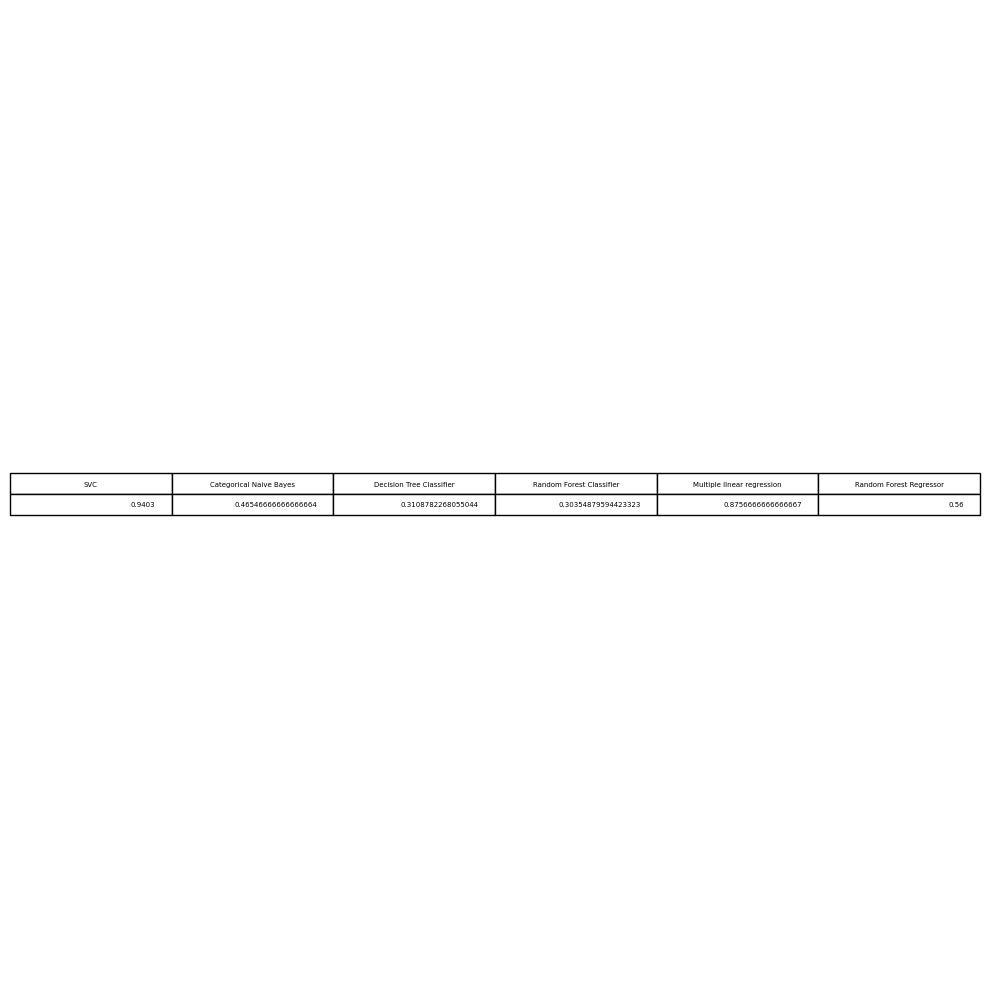

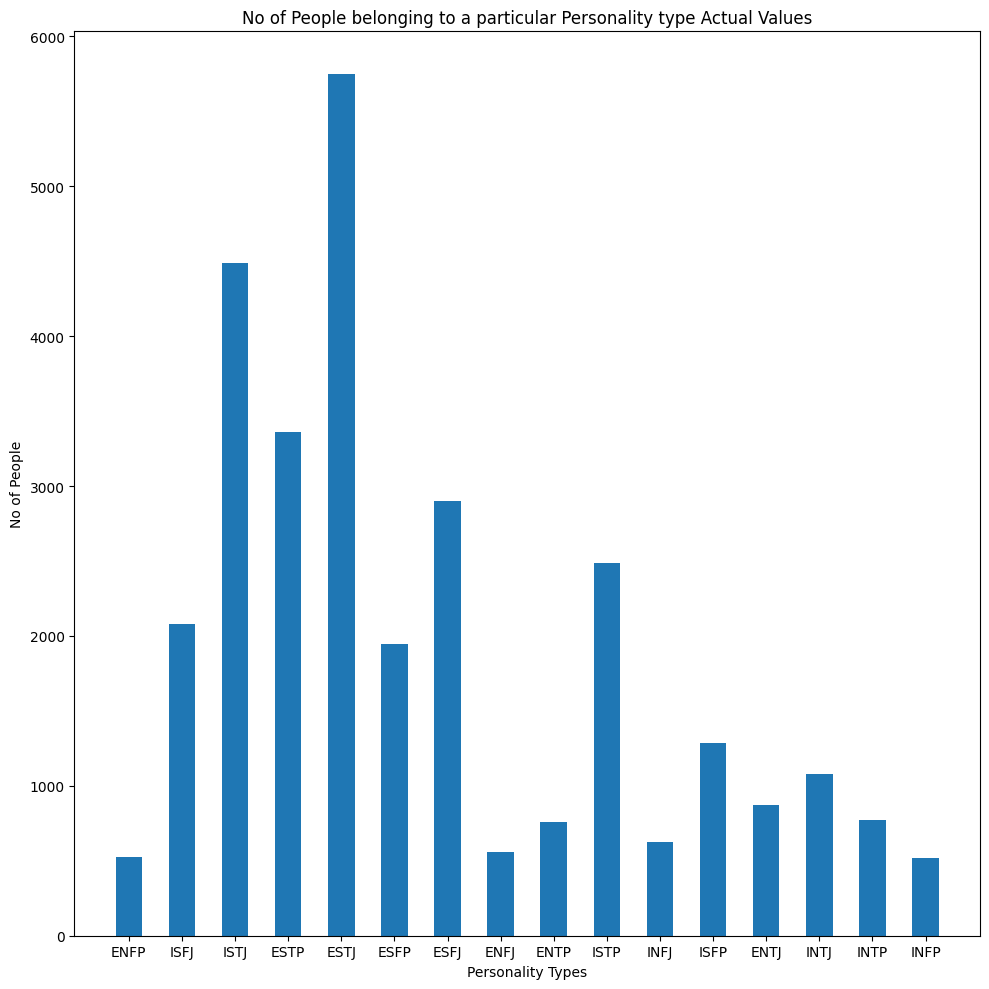

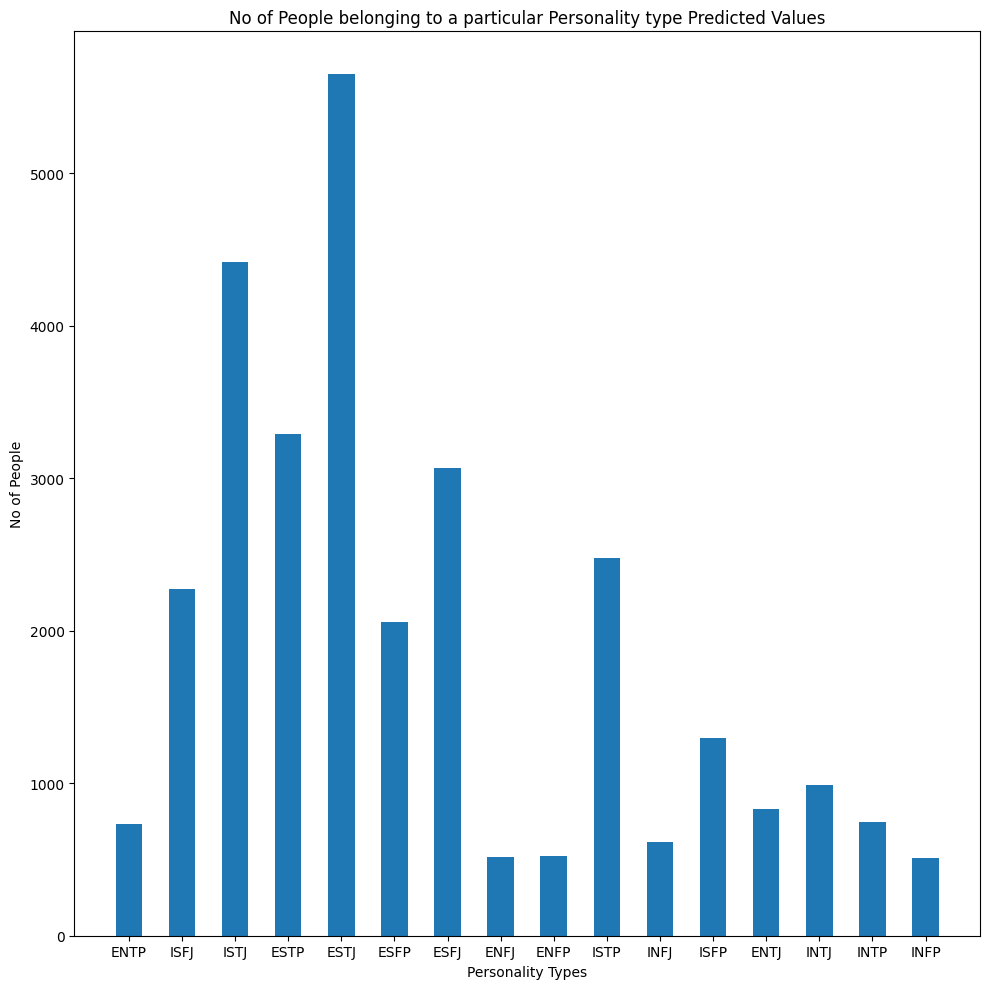

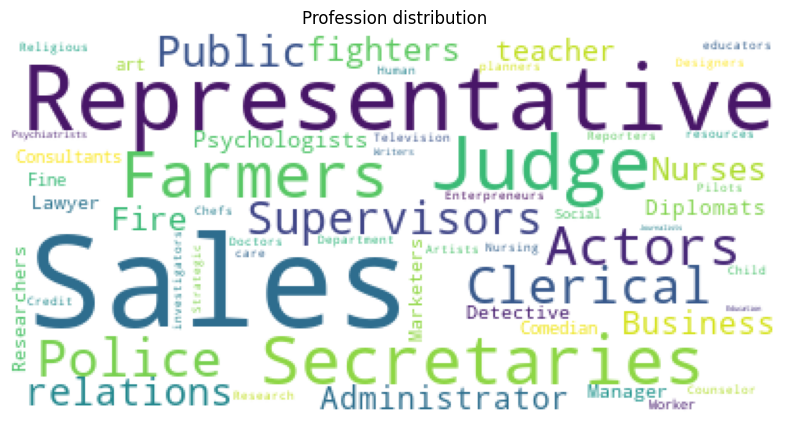

In [7]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import warnings
warnings.filterwarnings("ignore")
plt.rcParams["figure.figsize"] = [10, 10]
plt.rcParams["figure.autolayout"] = True
fig, axs = plt.subplots(1, 1)
data = [(accuracy_svc,accuracy_cnb,df_accuracy,accuracy,acc_mlr,acc_rf)]
columns = ("SVC", "Categorical Naive Bayes", "Decision Tree Classifier","Random Forest Classifier","Multiple linear regression","Random Forest Regressor")
axs.axis('tight')
axs.axis('off')
the_table = axs.table(cellText=data, colLabels=columns, loc='center')
plt.show()

plt.figure(figsize=(10, 10))
plt.bar(plot_orig.keys(),plot_orig.values(), width=0.5)
plt.xlabel("Personality Types")
plt.ylabel("No of People")
plt.title("No of People belonging to a particular Personality type Actual Values")
plt.show()
plt.figure(figsize=(10, 10))
plt.bar(plot_pred.keys(),plot_pred.values(),width=0.5)
plt.xlabel("Personality Types")
plt.ylabel("No of People")
plt.title("No of People belonging to a particular Personality type Predicted Values")
plt.show()
comment_words = ''
comment_words += " ".join(profs_mlr)+" "
word_cloud = WordCloud(collocations = False, background_color = 'white').generate(comment_words)
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(word_cloud)
plt.axis("off")
plt.title("Profession distribution")
plt.show()



## Refection

1. What issues did you encounter when aquiring and cleaning the data?<br>
Ans. After deciding upon Predicting KPMI/MBTI Personality the following challenges were encoutered:<br>
a. The majority of the datasets encountered used post-based personality prediction. Additionally, each post listed every personality type, which appeared inaccurate for training reasons. <br>
b. Some of the datasets included personality type data derived from age, gender, and other factors that weren't relevant to reaching our goals. <br>
c. The majority of the datasets were relatively dated (roughly 5 years ago), making them ineffective for training models. <br>
The dataset (file - kpmi ru data.csv) I've taken consists of responses to questionnaire questions (file - questionnaire schema.json), the responses are either 1 or 2. Dataset is gathered by the B2C personality prediction website kpmi.ru. It consisits of raw values (scales) of E, I, S, N, T, F, J, and P and the personality type (psychotype) based on the raw values are evaluated, the file also includes information on the amount of time required to respond to each question. <br>

2. What features did you use in your final model and why were others excluded?<br>
Ans. Initially I have trained my model by utilizing the answers to the questionnaire questions and trained it to provide personality type i.e., psychotype, here I have not taken the time taken to answer each question as well as the raw values of E,I,S,N,T,F,J, and P into consideration for training the model.<br>
Another stategy that I have applied is to utilize the answers to the questionnaire questions to train 8 models, where each model is trained to provide the raw values of E,I,S,N,T,F,J and P. Post that based on which has higher value in each dimension I have predicted the personality. <br>

3. Which ML methods did you use and why? Which performed best before you started tuning? Did things change after tuning?<br>
Ans. Since my problem statement is to categorize into 16 different Personality types I initially applied below classifier models <br>
a. SVC Support Vector Classifier, which is a supervised machine learning algorithm frequently used for classification tasks. Here the accuracy obtained is 94%. <br>
b. CategoricalNB Categorical Naive Bayes classifier, which is suitable for categorical classification with discrete features. Here the accuracy obtained is 57%. <br>
c. PySpark (PySpark is a library which is easy to use and scalable widely used for data analysis) Decision Tree Classifier to implement classification with Decision tree method. Here the accuracy obtained is 31%. <br>
d. PySpark Random Forest Classifier is a modified decision tree model that generates several decision trees and provides a combined result from all outputs. Here the accuracy obtained is 31%. <br>
As the accuracy is less another technique was applied to get the raw values of E,I,S,N,T,F,J and P <br>
e. Multiple Linear Regression, Like linear regression but with more than one independent value, i.e., to predict a value based on multiple vairbales. Here the accuracy obtained is 88%. <br>
f. Random Forest Regressor, which uses averaging to improve predictive accuracy and control over fining, fits a number of classifying decision trees on various sub samples of the dataset. Here the accuracy obtained is 57%. <br>
I have applied PCA (Principal Component Analysis) on multiple linear regression which is predicting raw values for each category in every dimension, where I have mentioned PAC(0.95), this 0.95 indicates that scikit-learn should select the fewest number of principal components necessary to retain 95% of the variance. <br>
On applying several percentage i.e., from 95 to 99 below has been observed : <br>
%tage  accuracy components<br>
0.95 - 0.71 52 <br>
0.96 - 0.74 54 <br>
0.97 - 0.76 55 <br>
0.98 - 0.76 57 <br>
0.99 - 0.80 60 <br>
It is observed that on applying PCA our accuracy has decreased, therefore, each of the variables i.e answers to the questions, independently contribute to train the model effectively. <br>

4. What was your accuracy before and then after cross validation? <br>
Ans. K-fold Cross Validation is when the data is split into k folds and train the model for each fold, hence evaluating model's abiity when provided a new data. Here I have applied 10-fold cross validation (on a smaller data set). The accuracy obtained before cross validation is 94% and after cross validation is 85%. Indicating that the more accurate accuracy is 85% of the SVC model and the original accuracy is less precise.<br>

5. What was the most challenging part of this project? <br>
Ans. For predicting the KPMI/MBTI Personality, I started with classification models, however, observed a drastic difference in the accuracy with SVC model giving 94% and Categorical Naive Bayes giving accuracy of 57%. Before trying other models using different libraries (pyspark) Decision Tree classifier and Random forest classifier, I applied String Indexer i.e., to convert my string into an index and then train the model, but here as well my accuracy was quite less. Therefore, I applied another technique where using the answers to the questions I predict the raw values of each type in each dimension, applying 8 models of Multiple linear regression, post which I compute the personality based on the values obtained for E,I,S,N,T,F,J and P and compare my prediction to actual value. Here I was able to achieve accuracy of 88%. <br>